<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/hypersonic_combustion_mhd_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypersonic Nozzle Flow Simulation with Combustion, Plasma, and MHD
This notebook implements a modular quasi-1D model using MacCormack's method to simulate:

- Compressible flow through a variable-area nozzle
- Localized Arrhenius combustion (species $Y_F$, $Y_P$)
- Plasma physics: electron and ion species, ionization energy
- MHD effects: Lorentz force, Joule heating
- Calculation of Mach number, temperature, pressure, and fuel consumption


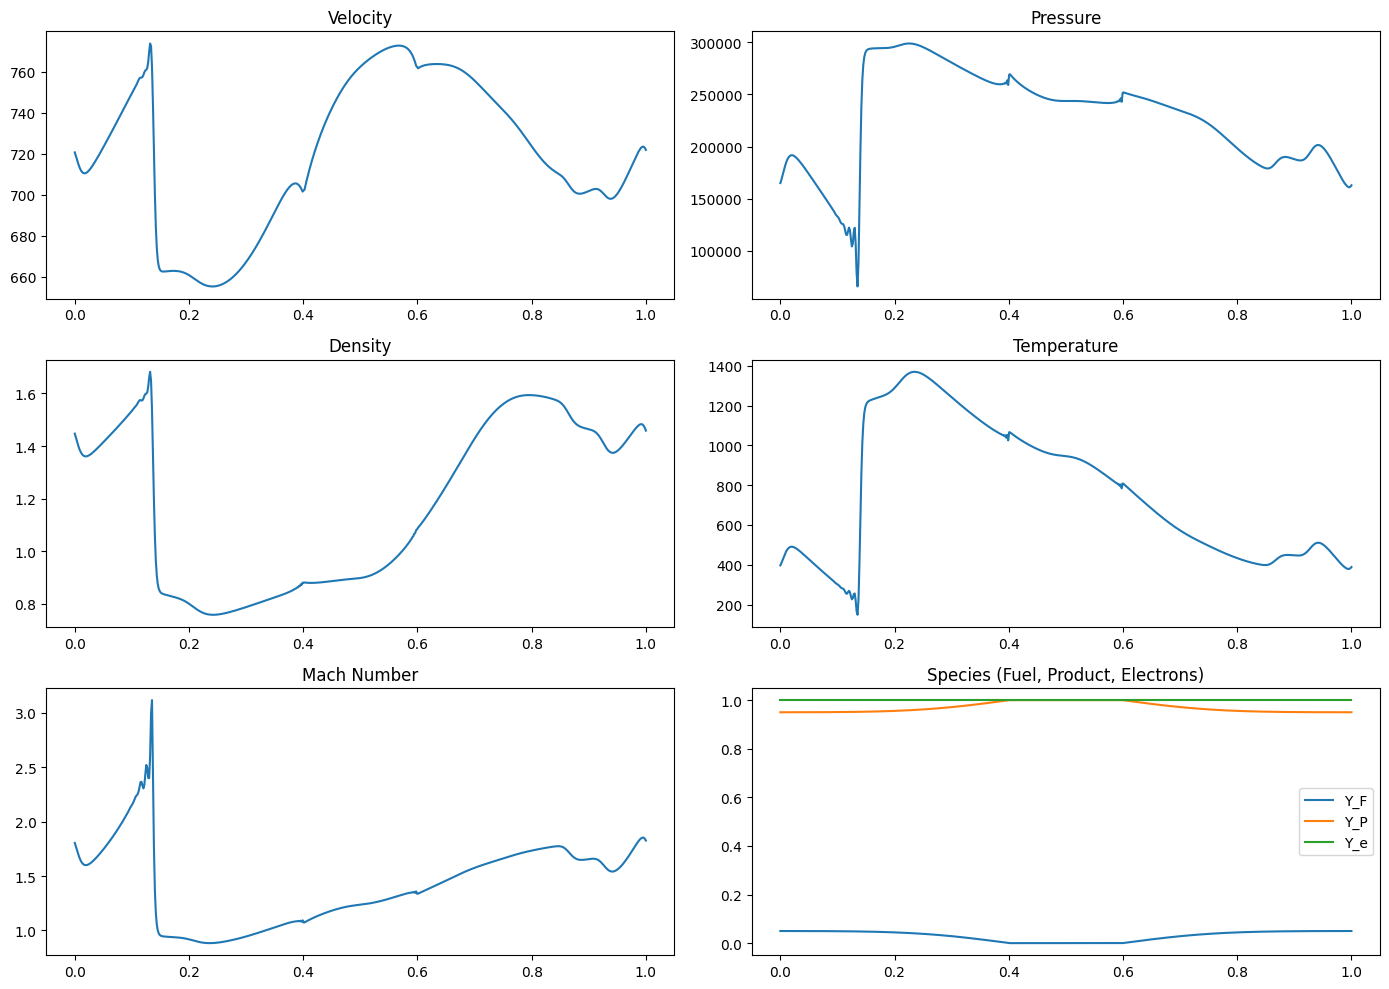

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Constants
gamma = 1.4
R = 287.0
nx = 600
x = np.linspace(0, 1.0, nx)
dx = x[1] - x[0]
A = 1 + 0.5 * np.exp(-((x - 0.5)/0.08)**2)

# Initial conditions
T = np.ones(nx) * 300.0
P = np.ones(nx) * 101325.0
rho = P / (R * T)
u = np.ones(nx) * 800.0
Y_F = np.ones(nx) * 0.05
Y_P = np.zeros(nx)
Y_e = np.zeros(nx)
Et = rho * (R * T / (gamma - 1) + 0.5 * u**2)

# Combustion parameters
A_preexp = 5e6
Ea = 1.2e5
q_release = 8e6
reaction_zone = (x > 0.4) & (x < 0.6)

# MHD parameters
B = np.ones(nx) * 0.2
E_ion = 13.6 * 1.6e-19
e_charge = 1.6e-19
m_e = 9.11e-31
sigma = np.exp(-E_ion / (1.38e-23 * T)) * e_charge**2 / (m_e * 1e10)

# Time loop settings
t = 0.0
t_end = 0.002
CFL = 0.3
eps = 0.005

while t < t_end:
    a = np.sqrt(gamma * R * T)
    dt = CFL * dx / np.max(np.abs(u) + a)

    omega = A_preexp * Y_F * np.exp(-Ea / np.maximum(R * T, 1e-8)) * reaction_zone
    omega = np.clip(omega, 0, 1e6)
    q_dot = q_release * omega
    sigma = np.exp(-E_ion / (1.38e-23 * T)) * e_charge**2 / (m_e * 1e10)
    f_L = sigma * B**2 * u
    q_joule = sigma * u**2 * B**2

    F1 = rho * u
    F2 = rho * u**2 + P
    F3 = (Et + P) * u

    rho_p = rho - dt/dx * (np.roll(F1, -1) - F1)
    u_p = (rho * u - dt/dx * (np.roll(F2, -1) - F2) + dt * f_L) / np.maximum(rho_p, 1e-6)
    Et_p = Et - dt/dx * (np.roll(F3, -1) - F3) + dt * (q_dot + q_joule)

    T_p = (Et_p / np.maximum(rho_p, 1e-6) - 0.5 * u_p**2) * (gamma - 1) / R
    P_p = rho_p * R * np.maximum(T_p, 10.0)

    F1_p = rho_p * u_p
    F2_p = rho_p * u_p**2 + P_p
    F3_p = (Et_p + P_p) * u_p

    rho = 0.5 * (rho + rho_p - dt/dx * (F1_p - np.roll(F1_p, 1)))
    u = 0.5 * ((rho * u + rho_p * u_p - dt/dx * (F2_p - np.roll(F2_p, 1))) / np.maximum(rho, 1e-6))
    Et = 0.5 * (Et + Et_p - dt/dx * (F3_p - np.roll(F3_p, 1))) + dt * (q_dot + q_joule)

    T = (Et / rho - 0.5 * u**2) * (gamma - 1) / R
    T = np.maximum(T, 10.0)
    P = rho * R * T

    Y_F = np.clip(Y_F - dt * omega, 0, 1)
    Y_P = 1 - Y_F
    Y_e = 1 - np.exp(-E_ion / (1.38e-23 * T))

    rho += eps * (np.roll(rho, -1) - 2 * rho + np.roll(rho, 1))
    Et += eps * (np.roll(Et, -1) - 2 * Et + np.roll(Et, 1))
    Y_F = 0.5 * (np.roll(Y_F, 1) + np.roll(Y_F, -1))
    u = 0.5 * (np.roll(u, 1) + np.roll(u, -1))
    t += dt

M = u / np.sqrt(gamma * R * T)
plt.figure(figsize=(14, 10))
plt.subplot(3,2,1); plt.plot(x, u); plt.title('Velocity')
plt.subplot(3,2,2); plt.plot(x, P); plt.title('Pressure')
plt.subplot(3,2,3); plt.plot(x, rho); plt.title('Density')
plt.subplot(3,2,4); plt.plot(x, T); plt.title('Temperature')
plt.subplot(3,2,5); plt.plot(x, M); plt.title('Mach Number')
plt.subplot(3,2,6); plt.plot(x, Y_F, label='Y_F'); plt.plot(x, Y_P, label='Y_P'); plt.plot(x, Y_e, label='Y_e'); plt.legend(); plt.title('Species (Fuel, Product, Electrons)')
plt.tight_layout()
plt.show()
